In [75]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from itertools import product

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from scipy.stats import mode

I pulled and cleaned a comprehensive dataset of colleges from this governmental database:
    
https://collegescorecard.ed.gov/data/

Let's read this dataset in:

In [76]:
df = pd.read_csv('data/schools.csv', index_col = 0)
print(df.shape)
df.head()

(6740, 46)


,name,ownership,ope6_id,state,size,accreditor,retention,branches,online_only,religious_affil,...,fafsa_sent,7_yr_repayment_completion,5_year_declining_balance,relig_y_n,accred_y_n,retention_listed_y_n,fac_salary_listed_y_n,7_yr_repayment_completion_y_n,5_year_declining_balance_y_n,for_profit
0,Alaska Bible College,2,8843,AK,27,Association for Bibical Higher Educaiton,0.333300,1,0,88.0,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
1,Alaska Christian College,2,41386,AK,68,Association for Bibical Higher Educaiton,0.473700,1,0,37.0,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
2,Ilisagvik College,1,34613,AK,109,Northwest Commission on Colleges and Universities,0.809500,1,0,-2.0,...,0.463652,0.699542,0.496850,0,1,1,1,0,0,0
3,Charter College-Anchorage,3,25769,AK,3256,Accrediting Council for Independent Colleges a...,0.703723,1,0,-2.0,...,0.310288,0.725806,0.417949,0,1,0,1,1,1,1
4,Alaska Career College,3,25410,AK,479,Accrediting Commission of Career Schools and C...,0.794100,1,0,-2.0,...,0.254237,0.556430,0.462520,0,1,1,1,1,1,1


We are going to use classification algorithms to try to predict for-profit or non-profit status. 

Some of the categories aren't applicable to what we want to do so let's consider the following columns only:


In [77]:
X = df[['size','retention','branches', 'online_only', 'under_investigation', 'most_common_degree', 'highest_degree',
       'faculty_salary', 'instructional_expenditure_per_fte',
       'tuition_revenue_per_fte', 'part_time_share',
       'age_entry', 'percent_dependent', 'first_generation', 'percent_black',
        'avg_family_income','ind_low_income', 'dep_low_income', 'loan_principal',
       'federal_loan_rate', 'students_with_any_loans',
       'pell_grant_debt', 'percent_pell_grant',
       'fafsa_sent', '7_yr_repayment_completion', '5_year_declining_balance',
       'relig_y_n', 'accred_y_n', 'retention_listed_y_n',
       'fac_salary_listed_y_n', '7_yr_repayment_completion_y_n',
       '5_year_declining_balance_y_n', 'for_profit']]
X.head()

,size,retention,branches,online_only,under_investigation,most_common_degree,highest_degree,faculty_salary,instructional_expenditure_per_fte,tuition_revenue_per_fte,...,fafsa_sent,7_yr_repayment_completion,5_year_declining_balance,relig_y_n,accred_y_n,retention_listed_y_n,fac_salary_listed_y_n,7_yr_repayment_completion_y_n,5_year_declining_balance_y_n,for_profit
0,27,0.333300,1,0,0,3,3,2201,9585,8132,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
1,68,0.473700,1,0,0,1,2,5554,18174,12989,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
2,109,0.809500,1,0,0,1,2,6054,38265,3587,...,0.463652,0.699542,0.496850,0,1,1,1,0,0,0
3,3256,0.703723,1,0,0,1,3,4004,2617,8755,...,0.310288,0.725806,0.417949,0,1,0,1,1,1,1
4,479,0.794100,1,0,0,1,2,3861,4178,11905,...,0.254237,0.556430,0.462520,0,1,1,1,1,1,1


Let's first use a method called [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) to see which features have the most statistically significant relationships with profit status. The **lower** the p value, the **more** statistically significant:

In [78]:
y = X.pop('for_profit')

X_new = SelectKBest(chi2, k=2).fit(X, y)

features = []
for i, column in enumerate(X.columns):
    features.append((X_new.pvalues_[i], column))
features.sort()
print('chi2-value', 'feature')
features

chi2-value feature


[(0.0, 'avg_family_income'),
 (0.0, 'branches'),
 (0.0, 'faculty_salary'),
 (0.0, 'instructional_expenditure_per_fte'),
 (0.0, 'loan_principal'),
 (0.0, 'pell_grant_debt'),
 (0.0, 'size'),
 (0.0, 'tuition_revenue_per_fte'),
 (5.339096890496358e-283, 'highest_degree'),
 (2.3550018048916394e-222, 'most_common_degree'),
 (5.4025502611485345e-149, 'fac_salary_listed_y_n'),
 (8.240679129762035e-148, 'relig_y_n'),
 (5.293172158552389e-143, 'age_entry'),
 (1.4125160311605584e-48, 'percent_dependent'),
 (1.4293811306586728e-24, '5_year_declining_balance'),
 (1.3527931483012968e-21, 'federal_loan_rate'),
 (6.095800240149601e-17, 'percent_black'),
 (3.249757484509366e-15, 'fafsa_sent'),
 (2.3099399670297893e-10, '7_yr_repayment_completion'),
 (5.332261659651424e-09, 'first_generation'),
 (1.407934457452164e-08, 'part_time_share'),
 (1.516370320447573e-08, 'dep_low_income'),
 (5.389960032435474e-08, 'percent_pell_grant'),
 (2.9423628117768117e-06, 'students_with_any_loans'),
 (9.035892891499908e-

1.Based on the info above, what was intuitive? What was surprising? How big (or small) of an effect does accredition have on for-profit status? What might be some guesses as to why this is the case?

In [45]:
#Intuitive: the average family income, branches, faculty salary, instructional expenditure per fte, loan principal, pell grant debt and size are the most relevant features in determining profit status.
#Surprising: the degree offered by the college doesn't have a lot effect on its profit status.
#Profit status has about 0.83 dependence on accreditation
#Accreditation is important because it provides a good reference to school selection, however, it is not the most determinant feature of profit status because some unaccreditated programs can also have valuable courses

2.Do a test/train split and give the testing accuracy error for logistic regression.

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.7)

model = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=10000)
model.fit(X_test, y_test)
print(model.score(X_test,y_test))

0.8982619754133108


3.Find the optimal number of nearest neighbors for KNN using grid search and then give the test accuracy. 

In [47]:
param_grid = {'n_neighbors': range(1, 20)}

model = GridSearchCV(KNeighborsClassifier(), 
                    param_grid, 
                    cv=3, 
                    scoring='accuracy')

model = model.fit(X_train, y_train)

print(model.best_params_, model.best_estimator_)

{'n_neighbors': 5} KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


In [48]:
model = model.best_estimator_

print(model.score(X_test, y_test))

0.8910555320050869


4.Run a classification report and describe in detail what the terms mean in the context of your model.

In [49]:
model = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=10000)
model.fit(X_train, y_train)

print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3835
           1       0.87      0.89      0.88      2905

    accuracy                           0.90      6740
   macro avg       0.90      0.90      0.90      6740
weighted avg       0.90      0.90      0.90      6740



In [50]:
#With a precision score of 92%, out of all cases predicted as profit, we find 98% of them. With a recall score of 90%, out of all digit non profits, we found 90% of them.
#With a precision score of 87%, out of all cases predicted as non profit, we find 87% of them. With a recall score of 90%, out of all digit profits , we found 90% of them.

5.Print a confusion matrix and describe what it means in your context.

In [51]:
confusion_matrix(y_test, model.predict(X_test))

array([[2394,  267],
       [ 228, 1829]])

In [52]:
model.classes_

array([0, 1])

In [53]:
#Out of all the non profit colleges, 2418 are correctly classified while 263 are incorrectly classified as profit
#Out of all the profit colleges, 1821 are correctly classified while 216 are incorrectly classified as non profit

6.Make a comparative ROC plot of the naive bayes, logistic, gradient boosting, and KNN classifiers.

In [18]:
X_scaler = StandardScaler()
X = X_scaler.fit_transform(X)
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-0.467851,-2.381226e+00,-0.302187,-0.075299,-0.101702,1.103434,0.562069,-2.285946,0.211986,-0.226511,...,-1.202430e-14,4.111456e-15,5.109826e-15,2.572123,0.115018,0.486049,0.789502,-1.232731,-1.862658,-0.870343
1,-0.460360,-1.478679e+00,-0.302187,-0.075299,-0.101702,-0.830804,-0.197423,-0.427946,1.104804,0.338821,...,-1.202430e-14,4.111456e-15,5.109826e-15,2.572123,0.115018,0.486049,0.789502,-1.232731,-1.862658,-0.870343
2,-0.452870,6.799767e-01,-0.302187,-0.075299,-0.101702,-0.830804,-0.197423,-0.150880,3.193243,-0.755528,...,-1.202430e-14,4.111456e-15,5.109826e-15,-0.388784,0.115018,0.486049,0.789502,-1.232731,-1.862658,-0.870343
3,0.122063,7.850651e-15,-0.302187,-0.075299,-0.101702,-0.830804,0.562069,-1.286848,-0.512331,-0.153997,...,-1.071621e+00,1.945300e-01,-4.539314e-01,-0.388784,0.115018,-2.057406,0.789502,0.811207,0.536867,1.148972
4,-0.385274,5.809794e-01,-0.302187,-0.075299,-0.101702,-0.830804,-0.197423,-1.366089,-0.350067,0.212648,...,-1.463269e+00,-1.059960e+00,-1.975064e-01,-0.388784,0.115018,0.486049,0.789502,0.811207,0.536867,1.148972


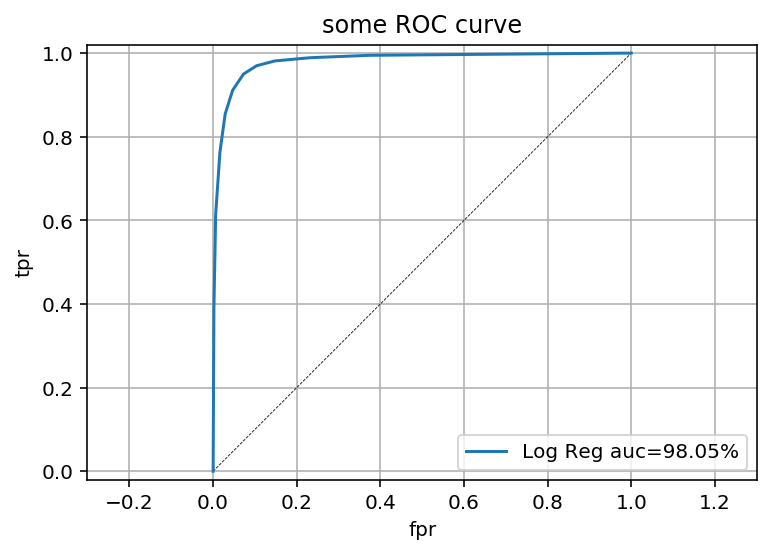

In [90]:
y_proba_LR = model.predict_proba(X_test)[:, 1]

def plot_roc(ytrue, yproba, model, title='some ROC curve'):
    auc = roc_auc_score(ytrue, yproba)
    fpr, tpr, thr = roc_curve(ytrue, yproba)
    plt.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=.4)
    plt.plot(fpr, tpr, label='{} auc={:.2f}%'.format(model, auc*100))
    plt.axis('equal')
    plt.xlim([-.02, 1.02])
    plt.ylim([-.02, 1.02])
    plt.ylabel('tpr')
    plt.xlabel('fpr')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    
plot_roc(y_test, y_proba_LR, "Log Reg")

In [91]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_proba_GB = model.predict_proba(X_test)[:, 1]

In [92]:
model = KNeighborsClassifier(n_neighbors = 3)
model.fit(X_train, y_train)
y_proba_KNN = model.predict_proba(X_test)[:, 1]

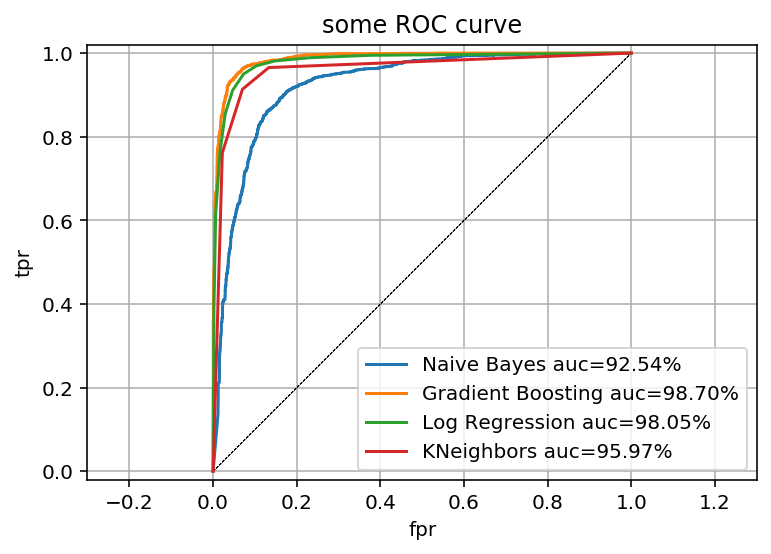

In [93]:
model = naive_bayes.GaussianNB()
model.fit(X_train, y_train)
y_proba_NB = model.predict_proba(X_test)[:, 1]

plot_roc(y_test, y_proba_NB, "Naive Bayes")
plot_roc(y_test, y_proba_GB, "Gradient Boosting")
plot_roc(y_test, y_proba_LR, "Log Regression")
plot_roc(y_test, y_proba_KNN, "KNeighbors")

7.Using the logarithmic regression model, plot a decision boundary between instructional_expenditure_per_fte and 5_year_declining_balance. Does it appear that for-profit status has a clear boundary based on these predictors?

In [8]:
X =df[['instructional_expenditure_per_fte','5_year_declining_balance']]
X_scaler = StandardScaler()
X = X_scaler.fit_transform(X)
X = pd.DataFrame(X)

In [9]:
model = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=10000)
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

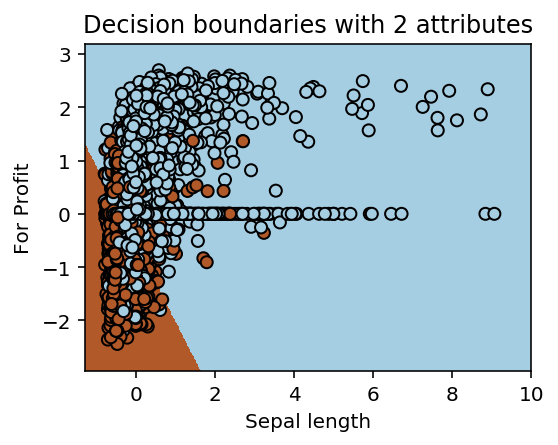

In [10]:
Q = X.values
h = .02  # meshsize
x_min, x_max = Q[:, 0].min() - .5, Q[:, 0].max() + .5 
y_min, y_max = Q[:, 1].min() - .5, Q[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
model.fit(X.iloc[:,0:2], y)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) # ravel() flattens the data

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(Q[:, 0], Q[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Decision boundaries with 2 attributes')
plt.xlabel('Sepal length')
plt.ylabel('For Profit')

plt.xlim(xx.min(), 10)
plt.ylim(yy.min(), yy.max())
plt.show()

8.We have not covered random forests but they are a very popular type of classifier. It is very good practice in reading the docs to get a new classifier working. Read [this](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and then apply the RandomForestClassifier().

In [88]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
print(model.feature_importances_)
print(model.score(X_test, y_test))
y_proba_RF = model.predict_proba(X_test)[:, 1]

[0.14313009 0.01213594 0.02933992 0.04619823 0.06407786 0.01315048
 0.07053381 0.06493158 0.01669086 0.03812701 0.08114242 0.03907387
 0.01321193 0.03661302 0.01644017 0.0128298  0.02292181 0.0344527
 0.03804569 0.01887642 0.02049526 0.02516675 0.03659061 0.03668337
 0.00313027 0.00066903 0.01076279 0.00543996 0.0033071  0.03919754
 0.00458174 0.00205196]
0.9347181008902077


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


9.Support vector machines are another type of classifier. Read the docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and then try implementing that one.

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6740 entries, 0 to 7541
Data columns (total 33 columns):
size                                 6740 non-null int64
retention                            6740 non-null float64
branches                             6740 non-null int64
online_only                          6740 non-null int64
under_investigation                  6740 non-null int64
most_common_degree                   6740 non-null int64
highest_degree                       6740 non-null int64
faculty_salary                       6740 non-null int64
instructional_expenditure_per_fte    6740 non-null int64
tuition_revenue_per_fte              6740 non-null int64
part_time_share                      6740 non-null float64
age_entry                            6740 non-null int64
percent_dependent                    6740 non-null float64
first_generation                     6740 non-null float64
percent_black                        6740 non-null float64
avg_family_income           

In [16]:
X.select_dtypes(exclude=["float_"])

,size,branches,online_only,under_investigation,most_common_degree,highest_degree,faculty_salary,instructional_expenditure_per_fte,tuition_revenue_per_fte,age_entry,avg_family_income,loan_principal,relig_y_n,accred_y_n,retention_listed_y_n,fac_salary_listed_y_n,7_yr_repayment_completion_y_n,5_year_declining_balance_y_n,for_profit
0,27,1,0,0,3,3,2201,9585,8132,21,49891,11443,1,1,1,1,0,0,0
1,68,1,0,0,1,2,5554,18174,12989,23,4140,5593,1,1,1,1,0,0,0
2,109,1,0,0,1,2,6054,38265,3587,25,13233,11443,0,1,1,1,0,0,0
3,3256,1,0,0,1,3,4004,2617,8755,28,26511,10047,0,1,0,1,1,1,1
4,479,1,0,0,1,2,3861,4178,11905,27,27548,7832,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7537,1976,1,0,0,2,2,6012,6574,2748,25,41341,5500,0,1,1,1,1,1,0
7538,2768,1,0,0,2,2,6451,7606,1881,25,43320,4500,0,1,1,1,1,1,0
7539,52,3,0,0,1,1,6326,8148,4570,26,23261,6354,0,1,1,0,1,1,1
7540,1085,2,0,0,1,2,6441,3104,13825,23,42518,9830,0,1,1,1,1,1,1


In [44]:
from sklearn.svm import SVC
# one_hot_online = pd.get_dummies(df['online_only'])
# one_hot_investigation = pd.get_dummies(df['under_investigation'])
# one_hot_religion = pd.get_dummies(df['relig_y_n'])
# one_hot_accredition = pd.get_dummies(df['accred_y_n'])
# one_hot_retention = pd.get_dummies(df['retention_listed_y_n'])
# one_hot_salary = pd.get_dummies(df['fac_salary_y_n'])
# one_hot_repayment = pd.get_dummies(df['7_yr_repayment_completion_y_n'])
# one_hot_declining = pd.get_dummies(df['5_year_declining_balance'])
# one_hot = one_hot_gender.join(one_hot_athletic)

y = X['for_profit']
numerical = X.drop(columns = ['online_only', 'under_investigation', 'relig_y_n', 'accred_y_n', 'retention_listed_y_n', 'fac_salary_listed_y_n','7_yr_repayment_completion_y_n','5_year_declining_balance','for_profit'])
numerical.head()
# model = make_pipeline(PolynomialFeatures(5), StandardScaler())
# model.fit(numerical)
# X = one_hot.join(pd.DataFrame(model.transform(numerical)))

# model = RidgeCV(cv=10, alphas=[0.0001, 0.1, 1])
# model.fit(X, y)
# print(model.score(X, y))

# X =df[['instructional_expenditure_per_fte','5_year_declining_balance']]
# X_scaler = StandardScaler()
# X = X_scaler.fit_transform(X)
# X = pd.DataFrame(X)
# model = svm.SVC(probability=True)
# #model = SVC(gamma='auto')
# model.fit(X_train, y_train)
# print(model.score(X_test, y_test))
# y_proba_SVM = model.predict_proba(X_test)[:, 1]

,size,retention,branches,most_common_degree,highest_degree,faculty_salary,instructional_expenditure_per_fte,tuition_revenue_per_fte,part_time_share,age_entry,...,ind_low_income,dep_low_income,loan_principal,federal_loan_rate,students_with_any_loans,pell_grant_debt,percent_pell_grant,fafsa_sent,7_yr_repayment_completion,5_year_declining_balance_y_n
0,27,0.333300,1,3,3,2201,9585,8132,0.1481,21,...,0.774400,0.476917,11443,0.2857,0.779431,12672.740204,0.723705,0.463652,0.699542,0
1,68,0.473700,1,1,2,5554,18174,12989,0.0735,23,...,0.774400,0.476917,5593,0.6792,0.747126,12672.740204,0.723705,0.463652,0.699542,0
2,109,0.809500,1,1,2,6054,38265,3587,0.6239,25,...,0.774400,0.476917,11443,0.0000,0.779431,12672.740204,0.723705,0.463652,0.699542,0
3,3256,0.703723,1,1,3,4004,2617,8755,0.0000,28,...,0.770715,0.485880,10047,0.7503,0.895096,10500.000000,0.849558,0.310288,0.725806,1
4,479,0.794100,1,1,2,3861,4178,11905,0.0000,27,...,0.787120,0.403846,7832,0.7860,0.814863,8400.500000,0.792699,0.254237,0.556430,1


In [86]:
X = df[['size','retention','branches', 'online_only', 'under_investigation', 'most_common_degree', 'highest_degree',
       'faculty_salary', 'instructional_expenditure_per_fte',
       'tuition_revenue_per_fte', 'part_time_share',
       'age_entry', 'percent_dependent', 'first_generation', 'percent_black',
        'avg_family_income','ind_low_income', 'dep_low_income', 'loan_principal',
       'federal_loan_rate', 'students_with_any_loans',
       'pell_grant_debt', 'percent_pell_grant',
       'fafsa_sent', '7_yr_repayment_completion', '5_year_declining_balance',
       'relig_y_n', 'accred_y_n', 'retention_listed_y_n',
       'fac_salary_listed_y_n', '7_yr_repayment_completion_y_n',
       '5_year_declining_balance_y_n', 'for_profit']]
X = X.reset_index(drop = True)

y = X.pop('for_profit')
numerical = X.drop(columns = ['online_only', 'under_investigation', 'relig_y_n', 'accred_y_n', 'retention_listed_y_n', 'fac_salary_listed_y_n','7_yr_repayment_completion_y_n','5_year_declining_balance_y_n'])
numerical_scaler = StandardScaler()
numerical = numerical_scaler.fit_transform(numerical)
numerical = pd.DataFrame(numerical)
categorical = X[['online_only', 'under_investigation', 'relig_y_n', 'accred_y_n', 'retention_listed_y_n', 'fac_salary_listed_y_n','7_yr_repayment_completion_y_n','5_year_declining_balance_y_n']]

X = numerical.join(categorical)


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.7)
model = svm.SVC(probability=True)
#model = SVC(gamma='auto')
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
y_proba_SVM = model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9355659177617635


10. Make a comparative ROC plot of the naive bayes, logistic, gradient boosting, KNN classifiers, random forest, and SVM classifiers.

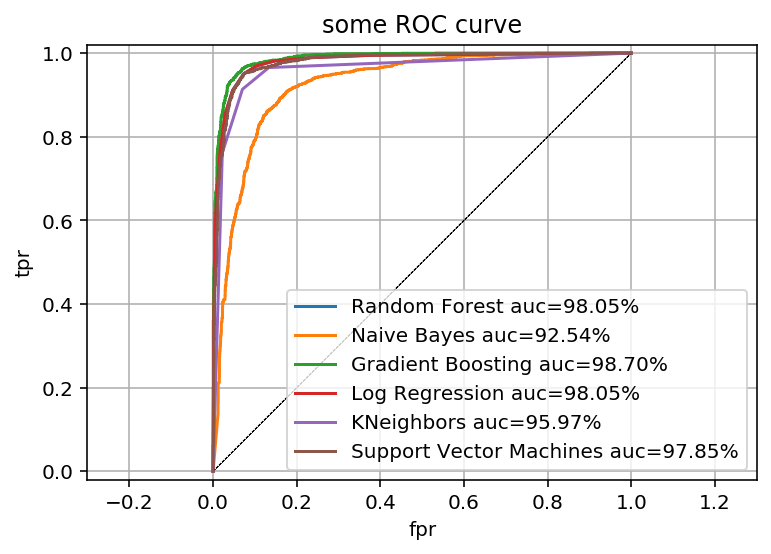

In [94]:
plot_roc(y_test, y_proba_RF, "Random Forest")
plot_roc(y_test, y_proba_NB, "Naive Bayes")
plot_roc(y_test, y_proba_GB, "Gradient Boosting")
plot_roc(y_test, y_proba_LR, "Log Regression")
plot_roc(y_test, y_proba_KNN, "KNeighbors")
plot_roc(y_test, y_proba_SVM, "Support Vector Machines")

11.Take in a new school's data and predict the school's profit status using one of your previous classifier methods.

In [9]:
X.iloc[12]

size                                    51.000000
retention                                0.600000
branches                                 1.000000
online_only                              0.000000
under_investigation                      0.000000
most_common_degree                       1.000000
highest_degree                           1.000000
faculty_salary                        6326.000000
instructional_expenditure_per_fte     3538.000000
tuition_revenue_per_fte               7437.000000
part_time_share                          0.000000
age_entry                               24.000000
percent_dependent                        0.456790
first_generation                         0.465120
percent_black                            0.156900
avg_family_income                    29230.000000
ind_low_income                           0.774400
dep_low_income                           0.476917
loan_principal                        9833.000000
federal_loan_rate                        0.753400


In [10]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
print(model.predict([[51, 0.6, 1, 0, 0, 1, 1, 6326, 3538, 7437, 0, 24, 0.45679, 0.46512, 0.1569, 29230, 0.7744, 0.476917, 9833, 0.7534, 0.779431, 12672.740204, 0.814815, 0.481481, 0.699542, 0.49685, 0, 1, 1, 0, 0, 0]]))

[1]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [12]:
#Check against the correct answer
df.iloc[12]

name                                         The Salon Professional Academy-Huntsville
ownership                                                                            3
ope6_id                                                                          42110
state                                                                               AL
size                                                                                51
accreditor                           National Accrediting Commission of Cosmetology...
retention                                                                          0.6
branches                                                                             1
online_only                                                                          0
religious_affil                                                                     -2
under_investigation                                                                  0
most_common_degree                         

12.What are the worst schools? Some of them are chains of schools so don't necessarily consider singular names but generalize to chains. Give a lot of justification for your analysis as everyone might have a different answer here. Insert these responses into your blog.

In [35]:
X_scaler = StandardScaler()
X = X_scaler.fit_transform(X)
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,-0.467851,-2.381226e+00,-0.302187,-0.075299,-0.101702,1.103434,0.562069,-2.285946,0.211986,-0.226511,...,3.900613e-15,5.033922e-15,2.572123,0.115018,0.486049,0.789502,-1.232731,-1.862658,-0.870343,-1.150444
1,-0.460360,-1.478679e+00,-0.302187,-0.075299,-0.101702,-0.830804,-0.197423,-0.427946,1.104804,0.338821,...,3.900613e-15,5.033922e-15,2.572123,0.115018,0.486049,0.789502,-1.232731,-1.862658,-0.870343,0.424614
2,-0.452870,6.799767e-01,-0.302187,-0.075299,-0.101702,-0.830804,-0.197423,-0.150880,3.193243,-0.755528,...,3.900613e-15,5.033922e-15,-0.388784,0.115018,0.486049,0.789502,-1.232731,-1.862658,-0.870343,-1.948859
3,0.122063,8.363001e-15,-0.302187,-0.075299,-0.101702,-0.830804,0.562069,-1.286848,-0.512331,-0.153997,...,1.945300e-01,-4.539314e-01,-0.388784,0.115018,-2.057406,0.789502,0.811207,0.536867,1.148972,0.296913
4,-0.385274,5.809794e-01,-0.302187,-0.075299,-0.101702,-0.830804,-0.197423,-1.366089,-0.350067,0.212648,...,-1.059960e+00,-1.975064e-01,-0.388784,0.115018,0.486049,0.789502,0.811207,0.536867,1.148972,0.254391


In [42]:
X['Worst_Schools'] = X[15] + X[2] + X[7] + X[8] + X[18] + (-1)*X[21] + X[0] + (-1)*X[9]
X.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,Worst_Schools
0,-0.467851,-2.381226e+00,-0.302187,-0.075299,-0.101702,1.103434,0.562069,-2.285946,0.211986,-0.226511,...,5.033922e-15,2.572123,0.115018,0.486049,0.789502,-1.232731,-1.862658,-0.870343,-1.150444,-2.049424
1,-0.460360,-1.478679e+00,-0.302187,-0.075299,-0.101702,-0.830804,-0.197423,-0.427946,1.104804,0.338821,...,5.033922e-15,2.572123,0.115018,0.486049,0.789502,-1.232731,-1.862658,-0.870343,0.424614,-3.077838
2,-0.452870,6.799767e-01,-0.302187,-0.075299,-0.101702,-0.830804,-0.197423,-0.150880,3.193243,-0.755528,...,5.033922e-15,-0.388784,0.115018,0.486049,0.789502,-1.232731,-1.862658,-0.870343,-1.948859,1.947547
3,0.122063,8.363001e-15,-0.302187,-0.075299,-0.101702,-0.830804,0.562069,-1.286848,-0.512331,-0.153997,...,-4.539314e-01,-0.388784,0.115018,-2.057406,0.789502,0.811207,0.536867,1.148972,0.296913,-2.190313
4,-0.385274,5.809794e-01,-0.302187,-0.075299,-0.101702,-0.830804,-0.197423,-1.366089,-0.350067,0.212648,...,-1.975064e-01,-0.388784,0.115018,0.486049,0.789502,0.811207,0.536867,1.148972,0.254391,-2.980308


In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6740 entries, 0 to 6739
Data columns (total 35 columns):
0                6740 non-null float64
1                6740 non-null float64
2                6740 non-null float64
3                6740 non-null float64
4                6740 non-null float64
5                6740 non-null float64
6                6740 non-null float64
7                6740 non-null float64
8                6740 non-null float64
9                6740 non-null float64
10               6740 non-null float64
11               6740 non-null float64
12               6740 non-null float64
13               6740 non-null float64
14               6740 non-null float64
15               6740 non-null float64
16               6740 non-null float64
17               6740 non-null float64
18               6740 non-null float64
19               6740 non-null float64
20               6740 non-null float64
21               6740 non-null float64
22               6740 non-null floa

In [44]:
X.Worst_Schools.value_counts().sort_index()

-20.227167    1
-13.714187    1
-8.761973     1
-8.642514     1
-8.246723     1
             ..
 18.687676    1
 18.818626    1
 20.356887    1
 28.023620    1
 36.499084    1
Name: Worst_Schools, Length: 6525, dtype: int64

In [45]:
X[(X.Worst_Schools <= -8)]

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,Worst_Schools
1232,-0.421447,1.306746e+00,-0.302187,-0.075299,-0.101702,0.136315,-0.197423,-2.175674,1.227568,17.913116,...,5.033922e-15,-0.388784,0.115018,0.486049,0.789502,-1.232731,-1.862658,1.148972,NaN,-20.227167
1358,-0.440630,6.189070e-01,-0.302187,-0.075299,-0.101702,-0.830804,-0.197423,-2.423925,2.259781,6.014605,...,5.033922e-15,-0.388784,0.115018,0.486049,0.789502,-1.232731,-1.862658,1.148972,NaN,-8.761973
1768,-0.471322,8.363001e-15,-0.302187,-0.075299,-0.101702,-0.830804,-0.956915,-0.000157,19.940155,27.808929,...,5.033922e-15,-0.388784,-8.694303,-2.057406,-1.266621,-1.232731,-1.862658,1.148972,NaN,-8.642514
6146,-0.465476,-2.379985e-01,-0.103451,-0.075299,-0.101702,-0.830804,-0.197423,-1.714637,1.313949,10.195059,...,5.033922e-15,-0.388784,0.115018,0.486049,0.789502,-1.232731,-1.862658,1.148972,NaN,-13.714187
6261,-0.465659,8.363001e-15,-0.302187,-0.075299,-0.101702,2.070553,1.321562,-1.196525,0.960211,7.015838,...,5.033922e-15,-0.388784,0.115018,-2.057406,0.789502,-1.232731,-1.862658,1.148972,NaN,-8.020073
6315,-0.443370,1.274604e+00,-0.302187,-0.075299,-0.101702,-0.830804,-0.956915,-0.000157,2.092215,8.404783,...,5.033922e-15,-0.388784,0.115018,0.486049,-1.266621,-1.232731,-1.862658,-0.870343,NaN,-8.246723


In [46]:
print(df.iloc[1232])
print(df.iloc[1358])
print(df.iloc[1768])
print(df.iloc[6146])
print(df.iloc[6261])
print(df.iloc[6315])

In [0]:
#The data is first scaled to eliminate the effects of the extreme data, so that each selected feature can be evaluated equally. Based on the information above, average family income, branches, faculty salary, instructional expenditure per fte, loan principal, pell grant debt, size, and tuition revenue per fte are the most important features in considering profit status, so these factors are chosen for evaluating worst schools. Because tuition revenue per fte and pell grant debt have negative correlations with profit status, a "-1" is multiplied to their values. The total of the precedent important features are calculated and put to a new column of the dataframe. The top six colleges with the lowest sum of important features are considered to be the worst schools.

13.If you were a governmental organization overseeing accreditation, what factors would be most important to you in making sure that the college was non-predatory? Give a lot of detail here as well in your blog.

In [0]:
#Based on the information above, average family income, branches, faculty salary, instructional expenditure per fte, loan principal, pell grant debt, size, and tuition revenue per fte are the most important features in considering accredition, because they have the most statistically significant relationships
#According to the US Department of Education, the basic eligibility requirements for recognition of accredition concern mostly with federal programs, accrediting experience and acceptance by others. Specifically in the application process, applicants have to illustrate factors like their purpose, administrative responsibilities, and most importantly, the connection of student achievements to the mission of the institute. 
#In conclusion, the profit status, student achievement and the mission of the college. A college can obtain accredition recognition in different agencies.

14.Read several articles on college predatory practices and cite and incorporate them into your blog discussion. Remember to link to them clearly by using the 
```[here](http://....)``` syntax.

In [4]:
import webbrowser
webbrowser.open("https://www2.ed.gov/admins/finaid/accred/accreditation-handbook.pdf")
webbrowser.open("https://www.petersons.com/blog/understanding-accreditation-of-us-colleges-and-universities/")

True